Requirements

In [1]:
!pip install torchvision

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.autograd.gradcheck import zero_gradients
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from torch.autograd import Variable
import json


Download Inceptionv3 model

In [3]:
inceptionv3 = models.inception_v3(pretrained=True) #download and load pretrained inceptionv3 model
inceptionv3.eval();

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Prepare Data

In [41]:
image_path = './images/car.jpg'
labels_path = 'labels.json'

#mean and std will remain same irresptive of the model you use
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

preprocess = transforms.Compose([
                transforms.Resize((299,299)),  
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

In [5]:
def load_image(image_path):
  img = Image.open(image_path)
  image_tensor = preprocess(img)
  image_tensor = image_tensor.unsqueeze(0)
  return image_tensor

In [47]:
def get_prediction(image_variable):
  with open(labels_path) as f:
    labels_json = json.load(f)
  
  prediction = inceptionv3.forward(image_variable)

  label_index = torch.max(prediction.data, 1)[1][0].item()
  labels = {int(idx):label for idx, label in labels_json.items()}
  x_pred_label = labels[label_index]

  pred_probs = F.softmax(prediction, dim = 1)
  x_pred_prob = round((torch.max(pred_probs.data, 1)[0].item()) * 100,4)

  return prediction, x_pred_label, x_pred_prob, label_index


Generate Attack

In [7]:
#perform a backward pass in order to get gradients
def cal_grad(prediction, image_variable, target):
  loss = torch.nn.CrossEntropyLoss()
  loss_cal = loss(prediction, target)
  loss_cal.backward(retain_graph=True) 
  return torch.sign(image_variable.grad.data)
     #this will calculate gradient of each variable (with requires_grad=True) and can be accessed by "var.grad.data"

In [45]:
def generate_ad_example(image_path, eps):
  # eps = 0.02
  image_tensor = load_image(image_path)
  image_variable = Variable(image_tensor, requires_grad=True)
  prediction, pred_label, pred_prob, label_index = get_prediction(image_variable)
  y_LL = torch.min(prediction.data, 1)[1][0]

  y_true = label_index
  y_true = y_LL.item()
  print(y_true)
  target = Variable(torch.LongTensor([y_true]), requires_grad=False)

  x_grad = cal_grad(prediction, image_variable, target)
  x_adversarial = image_variable.data + eps * x_grad
  adv_prediction, adv_label, adv_pred_prob, adv_label_index = get_prediction(x_adversarial)

  visualize(image_tensor, x_adversarial, x_grad, eps, pred_label, adv_label, pred_prob, adv_pred_prob)

Visualize Real and Adversarial Images

In [9]:
def visualize(x, x_adv, x_grad, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):
    
    x = x.squeeze(0)     #remove batch dimension # B X C H X W ==> C X H X W
    x = x.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op- "unnormalize"
    x = np.transpose( x , (1,2,0))   # C X H X W  ==>   H X W X C
    x = np.clip(x, 0, 1)
    
    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op
    x_adv = np.transpose( x_adv , (1,2,0))   # C X H X W  ==>   H X W X C
    x_adv = np.clip(x_adv, 0, 1)
    
    x_grad = x_grad.squeeze(0).numpy()
    x_grad = np.transpose(x_grad, (1,2,0))
    x_grad = np.clip(x_grad, 0, 1)
    
    figure, ax = plt.subplots(1,3, figsize=(18,8))
    ax[0].imshow(x)
    ax[0].set_title('Clean Example', fontsize=20)
    
    
    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=20)
    
    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center", 
             transform=ax[0].transAxes)
    
    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob), size=15, ha="center", 
         transform=ax[0].transAxes)
    
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob), size=15, ha="center", 
         transform=ax[2].transAxes)
    

    plt.show()


refrigerator, icebox
760
refrigerator, icebox


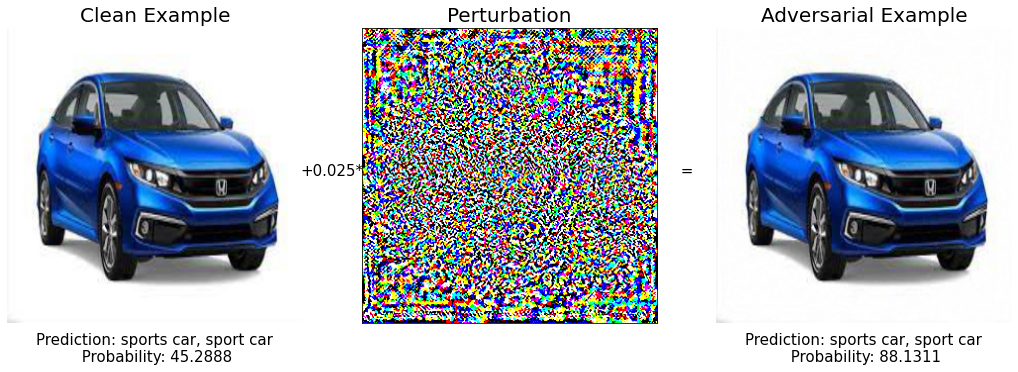

In [52]:
generate_ad_example(image_path, 0.025)

In [36]:

epsilon = [0.00088, 0.004, 0.01, 0.12, 0.55]

817


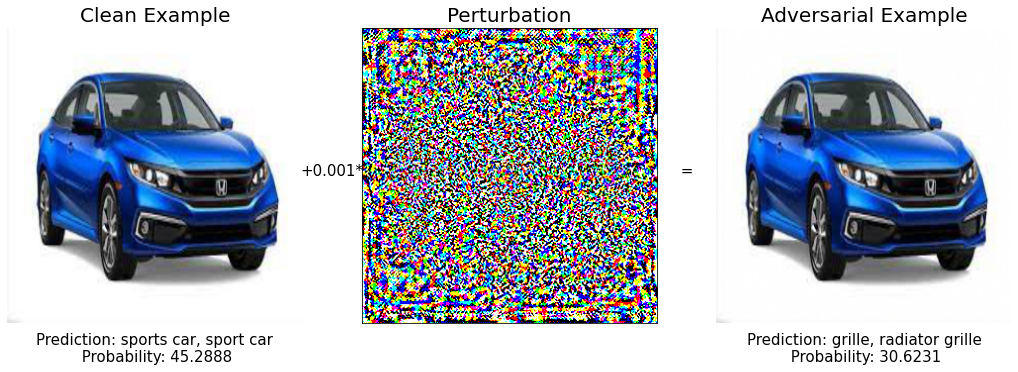

817


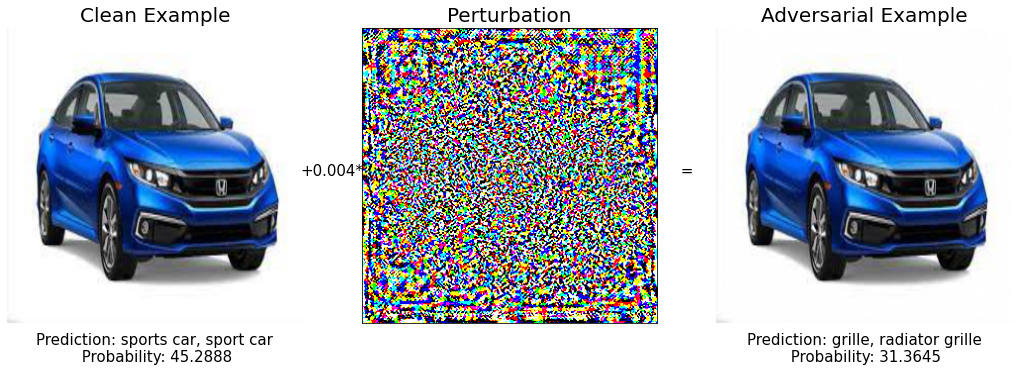

817


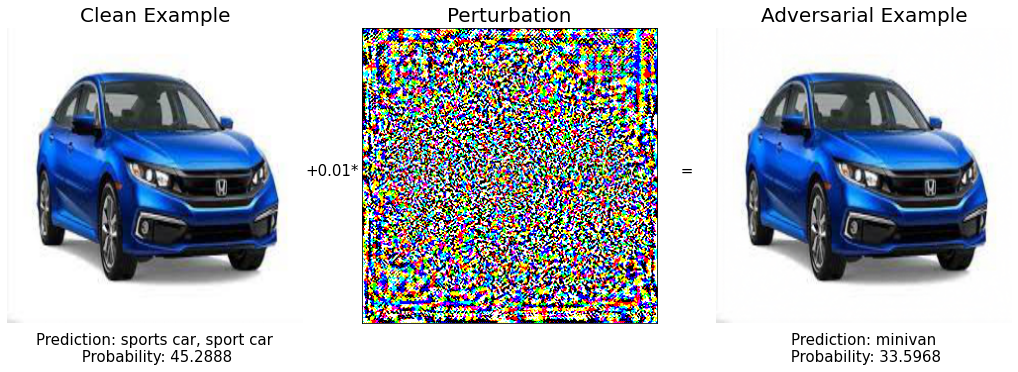

817


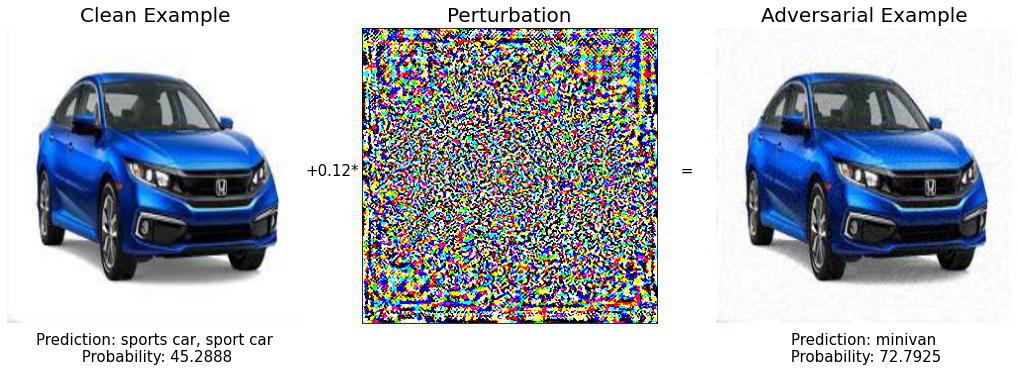

817


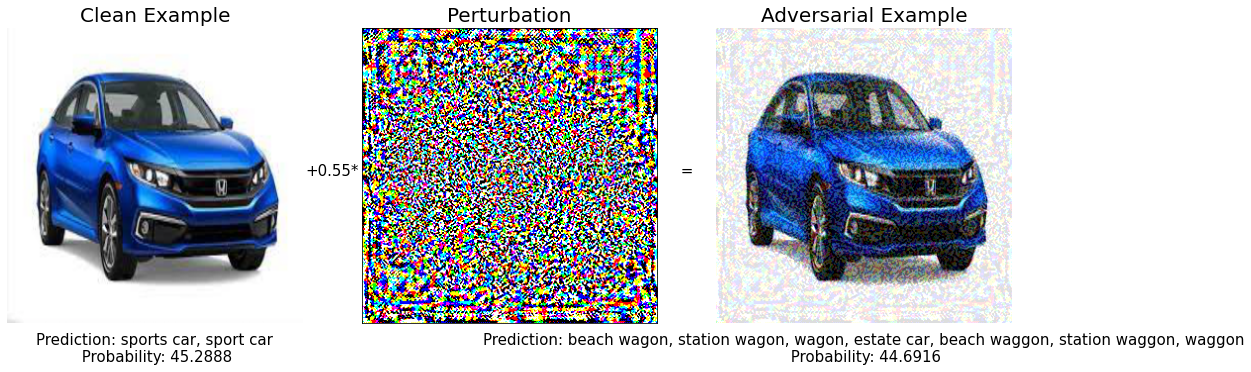

In [37]:
for i in epsilon:
  generate_ad_example(image_path, i)